# CONFLICTO ARMADO EN COLOMBIA

## Data Preproccessing

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import StandardScaler

In [84]:
odf=pd.read_csv('conflict_data_col.csv')

In [85]:
df = pd.read_csv('conflict_data_col.csv')
df.head()
df.columns


Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'iso3', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

In [86]:
df=df[['type_of_violence', 'year','side_a', 'side_b', 'adm_1', 'adm_2', 'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown']]
df.info

<bound method DataFrame.info of       type_of_violence        year                  side_a  \
0                  NaN  #date+year       #group+name+first   
1                  1.0        1989  Government of Colombia   
2                  1.0        1989  Government of Colombia   
3                  1.0        1989  Government of Colombia   
4                  1.0        1989  Government of Colombia   
...                ...         ...                     ...   
7468               3.0        2021         FARC dissidents   
7469               3.0        2021         FARC dissidents   
7470               3.0        2021         FARC dissidents   
7471               3.0        2021         FARC dissidents   
7472               2.0        2000                     ACC   

                  side_b                          adm_1  \
0     #group+name+second                     #adm1+name   
1                   FARC                            NaN   
2                   FARC           Santander d

In [87]:
df = df.rename(columns={'adm_1': 'departamento'})
df = df.rename(columns={'adm_2': 'municipio'})
df.columns

Index(['type_of_violence', 'year', 'side_a', 'side_b', 'departamento',
       'municipio', 'deaths_a', 'deaths_b', 'deaths_civilians',
       'deaths_unknown'],
      dtype='object')

Unknown Deaths

In [88]:
df['deaths_unknown'].sum()

1567.0

Unique values and definition of columns

In [89]:
unique_types_of_violence = df['type_of_violence'].unique()
unique_side_a = df['side_a'].unique()
unique_side_b = df['side_b'].unique()
unique_departamentos = df['departamento'].unique()
unique_municipios = df['municipio'].nunique()


# print the unique values
print("Unique types of violence:", unique_types_of_violence)
print("Unique side A:", unique_side_a)
print("Unique side B:", unique_side_b)
print("Unique departamentos:", unique_departamentos)
print("Unique municipios:", unique_municipios)



Unique types of violence: [nan  1.  3.  2.]
Unique side A: ['#group+name+first' 'Government of Colombia' 'Government of Venezuela'
 'FARC' 'ELN' 'ACCU' 'AUC' 'Medellín Cartel' 'Cali Cartel'
 'Bloque Central Bolívar' 'MAS' 'FARC dissidents' 'ACC']
Unique side B: ['#group+name+second' 'FARC' 'ELN' 'EPL' 'Civilians' 'Medellín Cartel'
 'PEPES' 'ELN, FARC' 'FARC dissidents' 'EPL - Megateo']
Unique departamentos: ['#adm1+name' nan 'Santander department' 'Cauca department'
 'Antioquia department' 'Meta department' 'Huila department'
 'Cesar department' 'Valle del Cauca department' 'Vichada department'
 'Tolima department' 'Putumayo department' 'Magdalena department'
 'Caldas department' 'Casanare department' 'Norte de Santander department'
 'Caquetá department' 'Chocó department' 'Bogotá department'
 'Cundinamarca department' 'Boyacá department' 'Guaviare department'
 'Arauca department' 'Bolívar department' 'Córdoba department'
 'La Guajira department' 'Nariño department' 'Sucre department'


In [90]:
df=df.drop(['municipio'], axis=1)
df = df[df['side_a'] != '#group+name+first']
df = df[df['side_b'] != '#group+name+second']
df = df[df['departamento'] != '#adm1+name']

In [91]:
df.columns

Index(['type_of_violence', 'year', 'side_a', 'side_b', 'departamento',
       'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown'],
      dtype='object')

In [92]:
df['sides'] = list(zip(df['side_a'], df['side_b']))
#df.drop(['side_a', 'side_b'], axis=1)
df['sides'].unique()

array([('Government of Colombia', 'FARC'),
       ('Government of Colombia', 'ELN'),
       ('Government of Colombia', 'EPL'),
       ('Government of Colombia', 'Civilians'),
       ('Government of Venezuela', 'Civilians'), ('FARC', 'Civilians'),
       ('ELN', 'Civilians'), ('ACCU', 'Civilians'), ('AUC', 'Civilians'),
       ('Medellín Cartel', 'Civilians'), ('AUC', 'FARC'), ('AUC', 'ELN'),
       ('Cali Cartel', 'Medellín Cartel'), ('Medellín Cartel', 'PEPES'),
       ('AUC', 'ELN, FARC'), ('Bloque Central Bolívar', 'Civilians'),
       ('MAS', 'Civilians'), ('Bloque Central Bolívar', 'ELN, FARC'),
       ('Government of Colombia', 'FARC dissidents'),
       ('Government of Colombia', 'EPL - Megateo'),
       ('FARC dissidents', 'Civilians'), ('ACC', 'FARC')], dtype=object)

In [93]:
df['sides'].nunique()

22

Data cleaning

In [94]:
# NaN values per column
for col in df.columns:
    nan_percentage = df[col].isna().mean() * 100
    print("Percentage of NaN values in", col, "column:", nan_percentage)


Percentage of NaN values in type_of_violence column: 0.0
Percentage of NaN values in year column: 0.0
Percentage of NaN values in side_a column: 0.0
Percentage of NaN values in side_b column: 0.0
Percentage of NaN values in departamento column: 3.0647751605995714
Percentage of NaN values in deaths_a column: 0.0
Percentage of NaN values in deaths_b column: 0.0
Percentage of NaN values in deaths_civilians column: 0.0
Percentage of NaN values in deaths_unknown column: 0.0
Percentage of NaN values in sides column: 0.0


In [95]:
df=df.dropna()

Categorical Columns

In [96]:
df.columns

Index(['type_of_violence', 'year', 'side_a', 'side_b', 'departamento',
       'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'sides'],
      dtype='object')

In [97]:
catCols1 = ['type_of_violence', 'side_a', 'side_b', 'departamento']
catCols2 = ['type_of_violence','sides', 'departamento']

df1 = pd.get_dummies(df, columns=catCols1)
df1 = df1.drop(['sides'], axis=1)

df2 = pd.get_dummies(df, columns=catCols2)
df2 = df2.drop(['side_a', 'side_b'], axis=1)

df2.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7243 entries, 2 to 7472
Data columns (total 62 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   year                                                 7243 non-null   object 
 1   deaths_a                                             7243 non-null   float64
 2   deaths_b                                             7243 non-null   float64
 3   deaths_civilians                                     7243 non-null   float64
 4   deaths_unknown                                       7243 non-null   float64
 5   type_of_violence_1.0                                 7243 non-null   uint8  
 6   type_of_violence_2.0                                 7243 non-null   uint8  
 7   type_of_violence_3.0                                 7243 non-null   uint8  
 8   sides_('ACC', 'FARC')                                7243 non-null  

## Insights and plots

In [98]:
df.columns

Index(['type_of_violence', 'year', 'side_a', 'side_b', 'departamento',
       'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'sides'],
      dtype='object')

In [126]:
1287/28411

0.045299355883284646

In [99]:
total_deaths = df['deaths_a'].sum() + df['deaths_b'].sum() + df['deaths_civilians'].sum() + df['deaths_unknown'].sum()
print('Total Deaths: ', total_deaths)
print('Civilian Deaths: ', df['deaths_civilians'].sum())
print('Different encounters: ', df['sides'].nunique())
print('Departamentos affected: ', df['departamento'].nunique())
print('Unknown deaths: ', df['deaths_unknown'].sum())

Total Deaths:  28411.0
Civilian Deaths:  9476.0
Different encounters:  22
Departamentos affected:  32
Unknown deaths:  1287.0


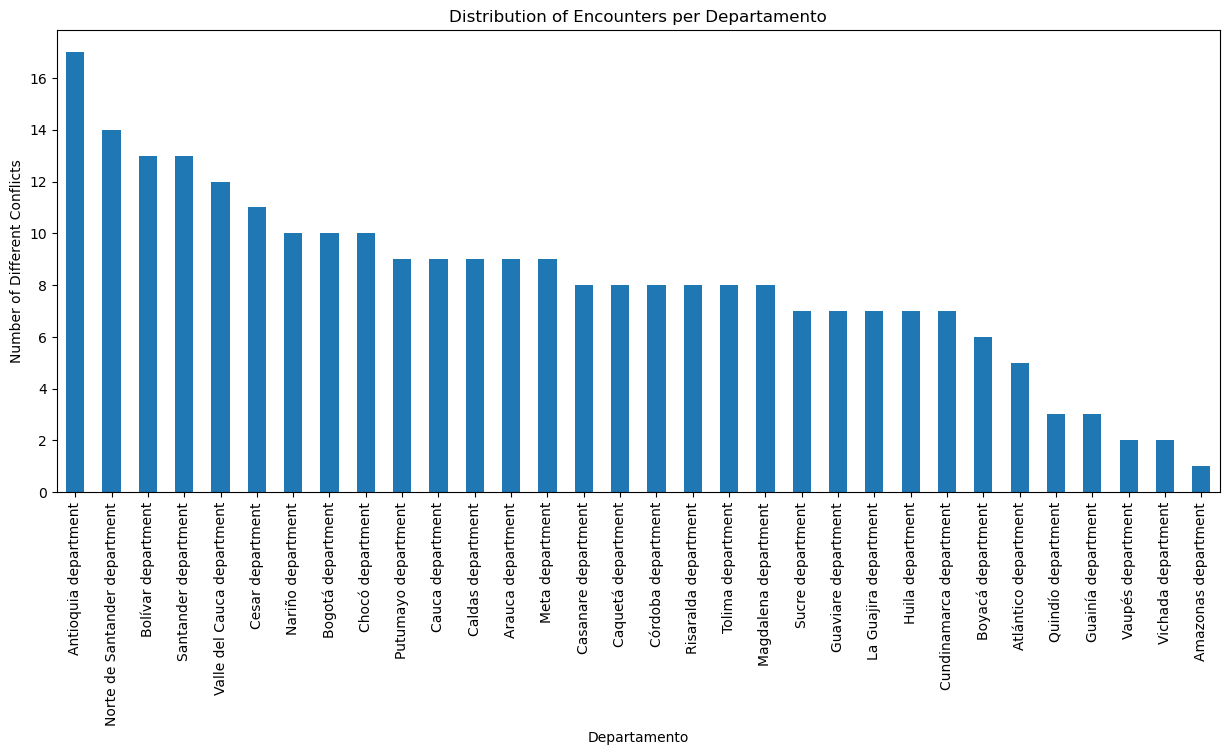

In [124]:
#DISTRIBUTION OF DIFFERENT CONFLICTS PER DEPARTAMENTO

# count the unique sides per departamento
sides_per_dept = df.groupby('departamento')['sides'].nunique()
sides_per_dept = sides_per_dept.sort_values(ascending=False)
sides_per_dept.plot(kind='bar', figsize=(15,6))
plt.title('Distribution of Encounters per Departamento')
plt.xlabel('Departamento')
plt.ylabel('Number of Different Conflicts')
plt.show()


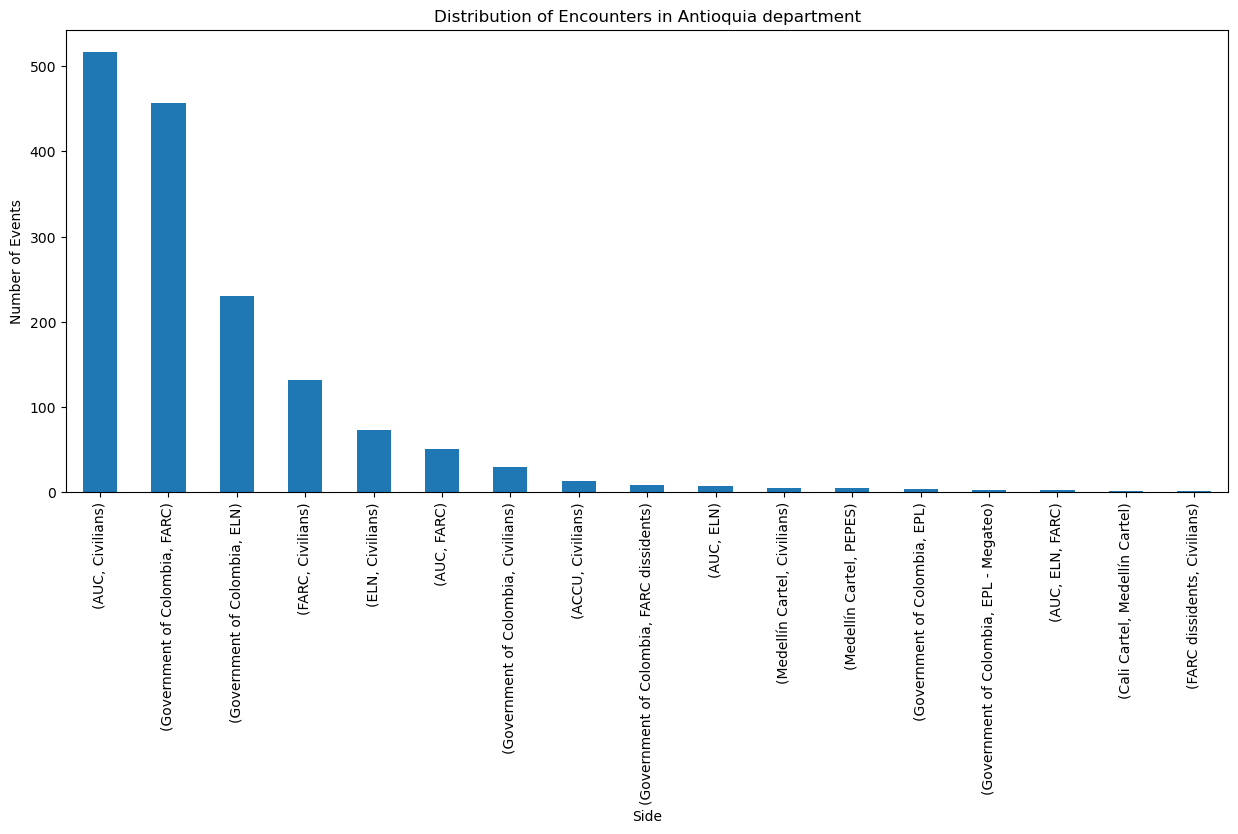

In [119]:
# DISTRIBUTION OF CONFLICTS PER DEPARTAMENTO
selected_dept = 'Antioquia department'
dept_data = df[df['departamento'] == selected_dept]
events_per_side = dept_data.groupby('sides')['type_of_violence'].count()
events_per_side = events_per_side.sort_values(ascending=False)
events_per_side.plot(kind='bar', figsize=(15,6))
plt.title(f'Distribution of Encounters in {selected_dept}')
plt.xlabel('Side')
plt.ylabel('Number of Events')
plt.show()


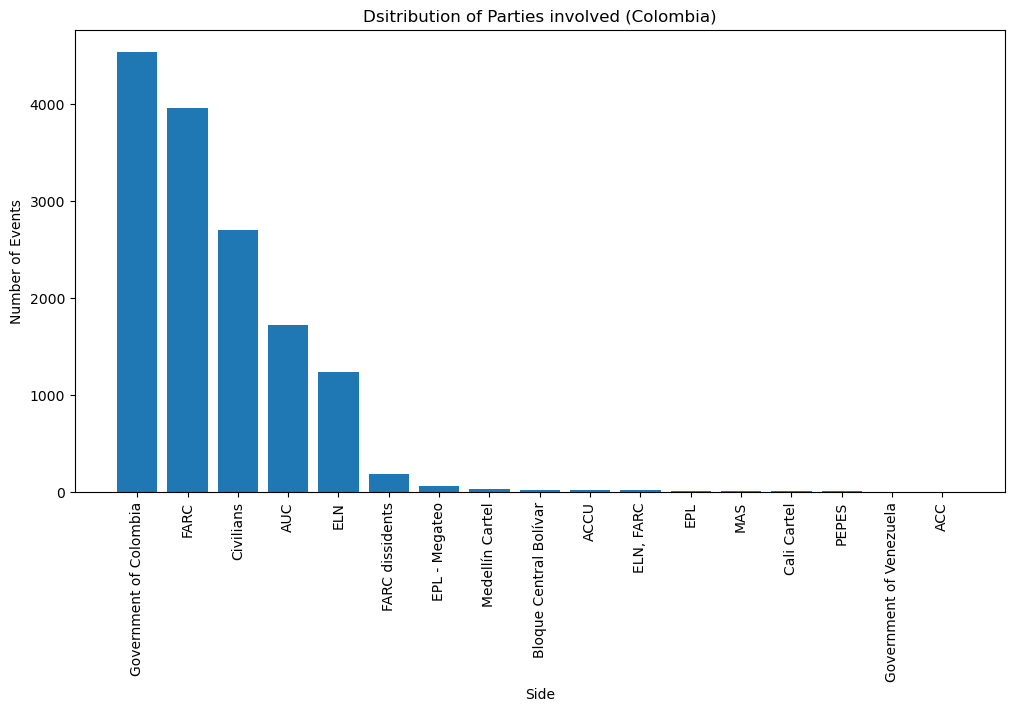

In [122]:
#FREQUENCY OF SIDES IN COLOMBIA
all_sides = pd.concat([df['side_a'], df['side_b']], ignore_index=True)
side_counts = all_sides.value_counts()

plt.figure(figsize=(12, 6))
plt.bar(side_counts.index, side_counts.values)
plt.xticks(rotation=90)
plt.title('Dsitribution of Parties involved (Colombia)')
plt.xlabel('Side')
plt.ylabel('Number of Events')
plt.show()

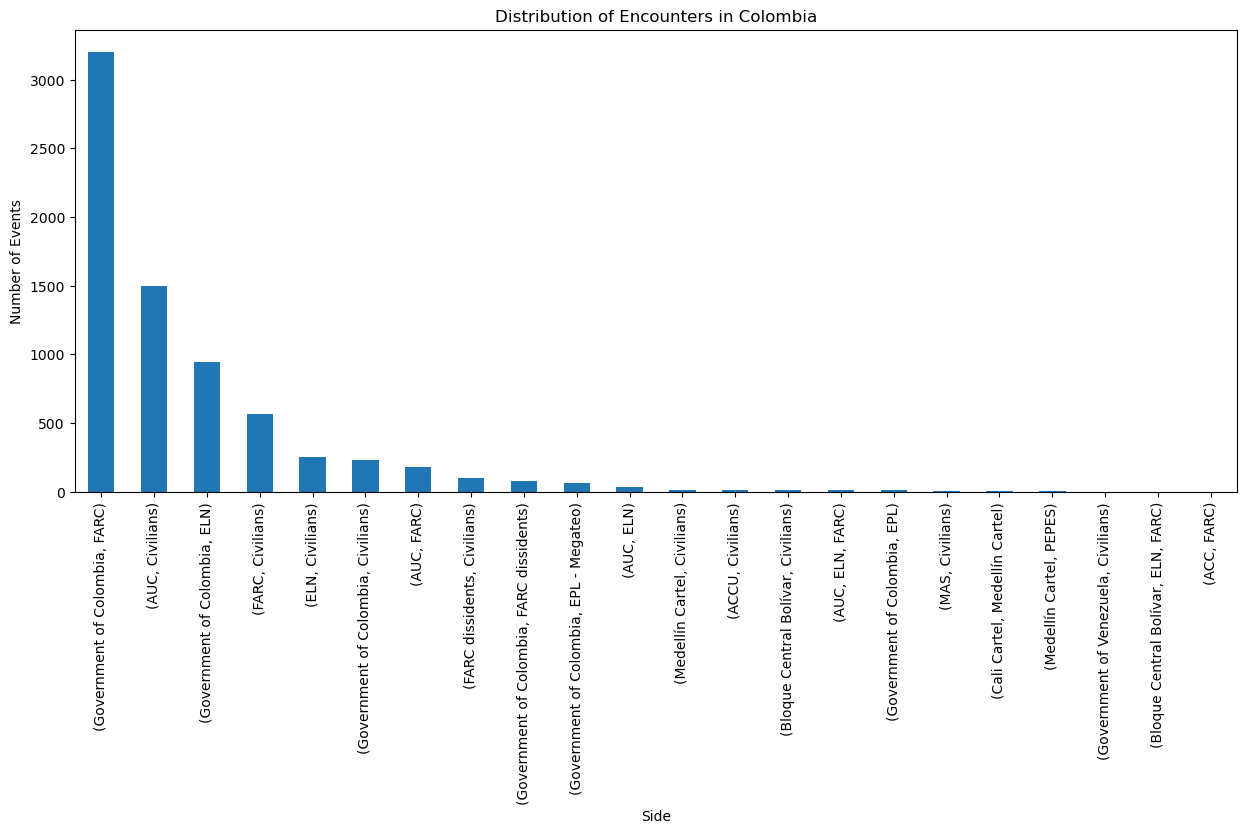

In [123]:
#FREQUENCY OF CONFLICTS IN COLOMBIA
events_per_side = df.groupby('sides')['type_of_violence'].count()

# plot the distribution as a bar plot
events_per_side = events_per_side.sort_values(ascending=False)
events_per_side.plot(kind='bar', figsize=(15,6))
plt.title(f'Distribution of Encounters in Colombia')
plt.xlabel('Side')
plt.ylabel('Number of Events')
plt.show()


C:\Users\Miguel Granados C\AppData\Local\Temp\ipykernel_12180\824934398.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  farc_deaths = farc.groupby('year')['deaths_civilians', 'deaths_a', 'deaths_b'].sum()
C:\Users\Miguel Granados C\AppData\Local\Temp\ipykernel_12180\824934398.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  government_deaths = government.groupby('year')['deaths_civilians', 'deaths_a', 'deaths_b'].sum()
C:\Users\Miguel Granados C\AppData\Local\Temp\ipykernel_12180\824934398.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  other_deaths = other_sides.groupby('year')['deaths_civilians', 'deaths_a', 'deaths_b'].sum()


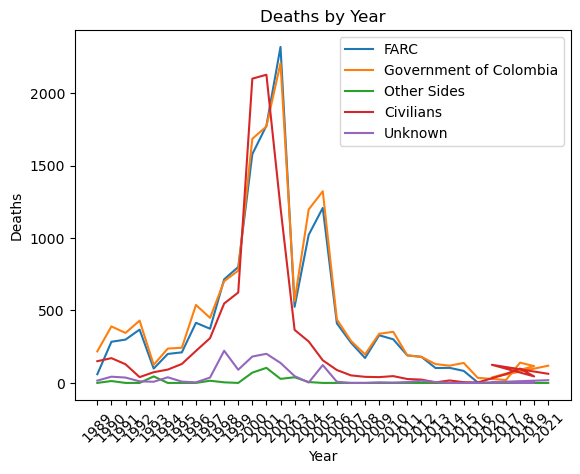

In [118]:
# Filter rows where side_A or side_B is 'FARC'
farc = df[(df['side_a'] == 'FARC') | (df['side_b'] == 'FARC')]

# Filter rows where side_A or side_B is 'Government of Colombia'
government = df[(df['side_a'] == 'Government of Colombia') | (df['side_b'] == 'Government of Colombia')]

# Filter rows where side_A and side_B are not 'FARC' or 'Government of Colombia'
other_sides = df[(df['side_a'] != 'FARC') & (df['side_a'] != 'Government of Colombia') & 
                 (df['side_b'] != 'FARC') & (df['side_b'] != 'Government of Colombia')]

# Group by year and sum deaths for each group
farc_deaths = farc.groupby('year')['deaths_civilians', 'deaths_a', 'deaths_b'].sum()
farc_deaths['deaths_FARC'] = farc_deaths['deaths_a'] + farc_deaths['deaths_b']
del farc_deaths['deaths_a']
del farc_deaths['deaths_b']

government_deaths = government.groupby('year')['deaths_civilians', 'deaths_a', 'deaths_b'].sum()
government_deaths['deaths_Government_of_Colombia'] = government_deaths['deaths_a'] + government_deaths['deaths_b']
del government_deaths['deaths_a']
del government_deaths['deaths_b']

other_deaths = other_sides.groupby('year')['deaths_civilians', 'deaths_a', 'deaths_b'].sum()
other_deaths['deaths_Other_Sides'] = other_deaths['deaths_a'] + other_deaths['deaths_b']
del other_deaths['deaths_a']
del other_deaths['deaths_b']

civilians_deaths = df.groupby('year')['deaths_civilians'].sum()
unknown_deaths = df.groupby('year')['deaths_unknown'].sum()
plt.xticks(rotation=45)

# Plot lines for each group
plt.plot(farc_deaths.index, farc_deaths['deaths_FARC'], label='FARC')
plt.plot(government_deaths.index, government_deaths['deaths_Government_of_Colombia'], label='Government of Colombia')
plt.plot(other_deaths.index, other_deaths['deaths_Other_Sides'], label='Other Sides')
plt.plot(civilians_deaths.index, civilians_deaths, label='Civilians')
plt.plot(unknown_deaths.index, unknown_deaths, label='Unknown')

# Set title, axis labels, and legend
plt.title('Deaths by Year')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.legend()


# Show the plot
plt.show()




## Predicting Unknown deaths

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assume that X contains all features except 'deaths_unknown' and y contains 'deaths_unknown' target variable
X = df2.drop(columns=['deaths_unknown'])
y = df2['deaths_unknown']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the model on the training set
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Evaluate the model performance using accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9696272434422457


c:\Users\Miguel Granados C\anaconda3\envs\equinox_base\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
